# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


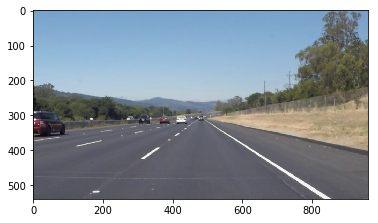

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [119]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def lineAnalyzer(list):
    ''' Takes in points in X1, Y1, X2, Y2 fashion, splits the points into two lists, and
    determines the largest and smallest point in the entirety of the two lists.
    '''
    firstPoints = [(a[0], a[1]) for a in list]
    secondPoints = [(a[2], a[3]) for a in list]
    minX, minY = min(min(firstPoints), min(secondPoints))
    maxX, maxY = max(max(firstPoints), max(secondPoints))
    
    return maxX, maxY, minX, minY

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    slope_threshold = 0.4
    positive_slope = []
    negative_slope = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if slope > slope_threshold:
                positive_slope.append(line[0]) # Some weird data type stuff here, it's a list of arrays of arrays
            if slope < slope_threshold * -1:
                negative_slope.append(line[0])

    # The lines in positive slope are all in the form (X1, Y1, X2, Y2), where Y2 is always greater than Y1 (lower
    # on the image). As such, we need to find the smallest Y1, and the largest Y2. This will give us the longest
    # line possible, which will reduce error.
    
    if not positive_slope or not negative_slope:
        return img
    
    # Y coords to extrapolate to
    topY = 325
    bottomY = 530
        
    maxX, maxY, minX, minY = lineAnalyzer(positive_slope)    
    slope = (maxY - minY) / (maxX - minX)
    # Extrapolate the line based on the data
    topX = minX - (minY - topY)*(1/slope)
    bottomX = maxX - (maxY - bottomY)*(1/slope)
    # Draw the line on the frame
    cv2.line(img, (int(topX), int(topY)), (int(bottomX), int(bottomY)), color, thickness)
        
    # Now repeat the process for the negative slope...    
    maxX, maxY, minX, minY = lineAnalyzer(negative_slope)
    slope = (maxY - minY) / (maxX - minX)
    
    topX = minX - (minY - topY)*(1/slope)
    bottomX = maxX - (maxY - bottomY)*(1/slope)

    cv2.line(img, (int(topX), int(topY)), (int(bottomX), int(bottomY)), color, thickness)

    return img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

784 491 559 358 0.591111111111
898 538 562 357 0.53869047619
854 538 540 347 0.608280254777
875 538 540 347 0.570149253731
658 417 511 334 0.56462585034
884 538 546 350 0.556213017751


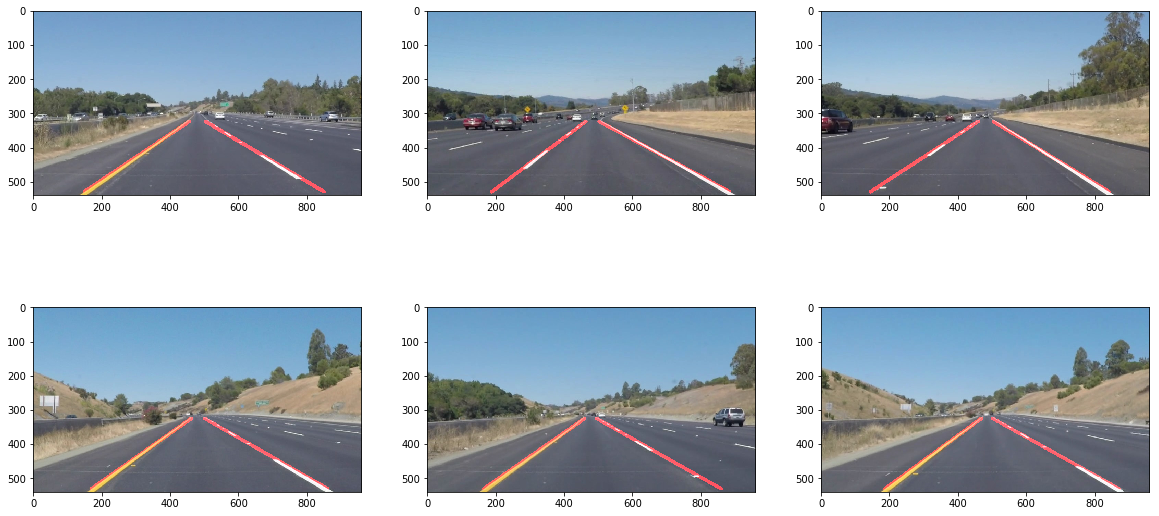

In [120]:
def process_image(image):
    # Convert image to gray
    gray = grayscale(image)
    
    imshape = image.shape # (rows, columns)
    height = imshape[0]
    width = imshape[1]

    # Blur the image to make line detection easier
    blur_gray = gaussian_blur(gray, kernel_size = 5)

    # Use Canny edge detection with experimentally determined thresholds to get edges in the image
    high_threshold = 250
    low_threshold = high_threshold / 2
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()    
    # Mask out the sky and sides of the image, we're only interested in the bottom portion where the road is 
    vertices = np.array([[(0, height), # Bottom Left
                          (width*0.49, height*0.6), 
                          (width*0.51, height*0.6), 
                          (width, height)]], dtype=np.int32) # Bottom Right
    ignore_mask_color = 255
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, ignore_mask_color)    
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 # minimum number of pixels making up a line
    max_line_gap = 60 # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)


    line_image = draw_lines(np.copy(image)*0, lines)
    
    if lines is None:        
        return image # If no lines were found in the image, return the original image
      
    # Draw the lines on the original image
    annotated_image = weighted_img(image, line_image)
    return annotated_image

# Set up some visualization to test the function and make parameter tweaking easier

f, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (20,10))

image = mpimg.imread('test_images/solidYellowLeft.jpg')
ax1.imshow(process_image(image))

image = mpimg.imread('test_images/solidWhiteCurve.jpg')
ax2.imshow(process_image(image))

image = mpimg.imread('test_images/solidWhiteRight.jpg')
ax3.imshow(process_image(image))

image = mpimg.imread('test_images/solidYellowCurve2.jpg')
ax4.imshow(process_image(image))

image = mpimg.imread('test_images/solidYellowCurve.jpg')
ax5.imshow(process_image(image))

image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
ax6.imshow(process_image(image))

plt.show()

# plt.imshow(process_image(image))

Let's try the one with the solid white lane on the right first ...

In [121]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) # NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

869 538 557 355 0.586538461538
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 4/222 [00:00<00:06, 35.04it/s]

869 538 557 355 0.586538461538
868 538 555 354 0.58785942492
868 539 555 354 0.591054313099
868 539 555 354 0.591054313099
870 539 557 355 0.58785942492
870 539 559 356 0.588424437299


  4%|▎         | 8/222 [00:00<00:06, 35.47it/s]

870 538 561 357 0.585760517799
873 538 561 357 0.580128205128


  5%|▌         | 12/222 [00:00<00:05, 35.58it/s]

871 539 557 355 0.585987261146
866 538 548 351 0.588050314465
860 538 533 344 0.593272171254
857 538 527 341 0.59696969697
855 539 529 342 0.604294478528
856 538 544 349 0.605769230769


  7%|▋         | 16/222 [00:00<00:05, 35.77it/s]

857 538 555 354 0.609271523179
859 539 562 357 0.612794612795


  9%|▉         | 20/222 [00:00<00:05, 34.56it/s]

860 538 566 359 0.608843537415
858 538 562 357 0.611486486486
856 538 551 352 0.609836065574
855 538 542 348 0.607028753994
854 538 538 346 0.607594936709
854 539 538 346 0.610759493671


 10%|█         | 23/222 [00:00<00:07, 27.37it/s]

854 538 538 346 0.607594936709
854 539 542 348 0.612179487179
855 539 552 353 0.613861386139
854 538 544 349 0.609677419355


 13%|█▎        | 29/222 [00:01<00:09, 21.11it/s]

855 538 544 349 0.607717041801
855 539 544 349 0.610932475884
856 538 542 348 0.605095541401
857 538 546 350 0.604501607717
857 538 550 352 0.605863192182
858 538 550 352 0.603896103896


 15%|█▌        | 34/222 [00:01<00:13, 14.14it/s]

858 538 551 352 0.605863192182
858 539 550 352 0.607142857143
856 538 546 350 0.606451612903


 17%|█▋        | 38/222 [00:01<00:15, 11.66it/s]

855 538 542 348 0.607028753994
855 539 546 350 0.611650485437
854 538 546 350 0.61038961039
854 539 553 354 0.614617940199


 18%|█▊        | 41/222 [00:02<00:13, 13.87it/s]

854 539 551 352 0.617161716172
855 539 555 354 0.616666666667
855 538 555 354 0.613333333333


 19%|█▉        | 43/222 [00:02<00:16, 10.55it/s]

854 539 555 354 0.61872909699
855 539 557 355 0.61744966443


 20%|██        | 45/222 [00:02<00:19,  9.16it/s]

854 538 555 354 0.615384615385
855 538 555 354 0.613333333333
855 539 557 355 0.61744966443


 21%|██        | 47/222 [00:03<00:24,  7.17it/s]

854 538 555 354 0.615384615385


 22%|██▏       | 49/222 [00:03<00:29,  5.86it/s]

854 538 555 354 0.615384615385
853 539 553 353 0.62


 23%|██▎       | 50/222 [00:03<00:33,  5.12it/s]

853 538 555 354 0.61744966443


 24%|██▍       | 53/222 [00:04<00:33,  5.12it/s]

853 538 555 354 0.61744966443
853 538 555 354 0.61744966443
852 538 551 352 0.617940199336


 25%|██▍       | 55/222 [00:04<00:29,  5.58it/s]

853 538 551 352 0.615894039735
852 538 552 353 0.616666666667


 27%|██▋       | 61/222 [00:04<00:17,  9.22it/s]

852 538 538 346 0.611464968153
850 539 533 344 0.615141955836
849 539 538 346 0.620578778135
848 539 538 346 0.622580645161
845 539 537 346 0.626623376623


 30%|██▉       | 66/222 [00:05<00:11, 13.16it/s]

844 539 531 343 0.626198083067
844 539 533 344 0.627009646302
842 537 529 342 0.623003194888
842 539 529 342 0.629392971246
842 539 527 341 0.628571428571


 31%|███       | 68/222 [00:05<00:10, 14.11it/s]

845 538 537 346 0.623376623377
847 538 537 346 0.61935483871
847 538 537 346 0.61935483871
844 539 533 344 0.627009646302
844 539 535 345 0.62783171521


 33%|███▎      | 74/222 [00:05<00:07, 18.93it/s]

844 538 537 346 0.625407166124
843 538 531 343 0.625
842 539 529 342 0.629392971246
842 538 529 342 0.626198083067
841 538 533 344 0.62987012987


 36%|███▌      | 80/222 [00:05<00:07, 19.87it/s]

840 539 533 344 0.635179153094
839 539 531 343 0.636363636364
837 538 531 343 0.637254901961
835 539 531 343 0.644736842105
835 538 533 344 0.64238410596


 39%|███▊      | 86/222 [00:05<00:06, 22.38it/s]

834 538 531 343 0.643564356436
833 538 531 343 0.645695364238
832 538 533 344 0.648829431438
832 538 531 343 0.647840531561
832 538 533 344 0.648829431438
832 538 533 344 0.648829431438


 41%|████▏     | 92/222 [00:06<00:05, 22.07it/s]

831 538 533 344 0.651006711409
830 539 533 344 0.656565656566
830 539 538 346 0.66095890411
829 539 535 345 0.659863945578
829 539 537 346 0.66095890411
828 539 538 346 0.665517241379


 43%|████▎     | 95/222 [00:06<00:05, 22.80it/s]

828 538 538 346 0.662068965517
830 539 544 349 0.664335664336
831 539 548 351 0.664310954064
832 539 550 352 0.663120567376
831 538 551 352 0.664285714286


 45%|████▌     | 101/222 [00:06<00:06, 18.84it/s]

831 538 553 353 0.665467625899
833 539 557 355 0.666666666667
832 539 555 354 0.667870036101
832 538 551 352 0.661921708185


 47%|████▋     | 104/222 [00:06<00:06, 19.00it/s]

832 539 552 353 0.664285714286
833 539 548 351 0.659649122807
835 539 551 352 0.658450704225
836 539 555 354 0.658362989324


 50%|████▉     | 110/222 [00:07<00:05, 19.18it/s]

837 539 559 356 0.658273381295
838 539 559 356 0.655913978495
838 539 559 356 0.655913978495
838 539 557 355 0.654804270463


 51%|█████     | 113/222 [00:07<00:05, 20.14it/s]

838 538 553 353 0.649122807018
838 539 553 353 0.652631578947
840 538 555 354 0.645614035088
841 539 557 355 0.647887323944
843 538 564 358 0.645161290323


 54%|█████▎    | 119/222 [00:07<00:05, 20.59it/s]

844 539 564 358 0.646428571429
846 538 564 358 0.63829787234
846 538 557 355 0.63321799308
848 538 559 356 0.629757785467


 55%|█████▍    | 122/222 [00:07<00:04, 21.95it/s]

848 538 555 354 0.627986348123
850 539 551 352 0.625418060201
851 538 550 352 0.617940199336
852 539 548 351 0.618421052632
852 539 551 352 0.621262458472


 58%|█████▊    | 128/222 [00:08<00:04, 19.26it/s]

854 539 557 355 0.619528619529
855 538 551 352 0.611842105263
858 538 553 353 0.606557377049
859 538 553 353 0.604575163399


 59%|█████▊    | 130/222 [00:08<00:04, 19.02it/s]

859 538 553 353 0.604575163399
859 538 551 352 0.603896103896
860 539 551 352 0.605177993528
859 538 551 352 0.603896103896


 62%|██████▏   | 137/222 [00:08<00:04, 17.64it/s]

860 538 551 352 0.601941747573
860 539 557 355 0.607260726073
861 538 564 358 0.606060606061
863 538 570 361 0.60409556314
864 538 572 362 0.602739726027


 63%|██████▎   | 140/222 [00:08<00:04, 17.60it/s]

866 538 570 361 0.597972972973
863 538 564 358 0.602006688963
862 538 562 357 0.603333333333
861 539 557 355 0.605263157895


 64%|██████▍   | 143/222 [00:08<00:04, 19.58it/s]

859 539 559 356 0.61
859 539 553 353 0.607843137255
859 539 559 356 0.61
859 538 559 356 0.606666666667


 67%|██████▋   | 148/222 [00:09<00:04, 16.52it/s]

863 538 564 358 0.602006688963
865 538 570 361 0.6
868 538 574 363 0.595238095238
871 538 577 364 0.591836734694
872 538 575 363 0.589225589226


 69%|██████▉   | 153/222 [00:09<00:03, 18.68it/s]

872 538 577 364 0.589830508475
870 538 574 363 0.591216216216
868 539 575 363 0.600682593857
868 539 579 365 0.602076124567
869 538 581 366 0.597222222222


 72%|███████▏  | 159/222 [00:09<00:03, 19.35it/s]

871 539 586 368 0.6
872 538 586 368 0.594405594406
874 539 586 368 0.59375
877 538 592 371 0.585964912281


 73%|███████▎  | 162/222 [00:09<00:03, 18.56it/s]

880 538 586 368 0.578231292517
882 538 586 368 0.574324324324
883 539 588 369 0.576271186441
885 538 586 368 0.56856187291
885 539 586 368 0.571906354515


 76%|███████▌  | 168/222 [00:10<00:02, 20.13it/s]

887 538 575 363 0.560897435897
887 538 575 363 0.560897435897
885 538 566 359 0.561128526646
886 538 562 357 0.558641975309
885 538 562 357 0.560371517028


 77%|███████▋  | 171/222 [00:10<00:02, 21.47it/s]

885 539 562 357 0.56346749226
885 538 562 357 0.560371517028
884 539 562 357 0.565217391304
885 538 566 359 0.561128526646
885 538 570 361 0.561904761905


 80%|███████▉  | 177/222 [00:10<00:02, 18.79it/s]

886 539 570 361 0.563291139241
886 538 570 361 0.560126582278
885 538 568 360 0.561514195584


 81%|████████  | 180/222 [00:10<00:02, 19.70it/s]

886 538 574 363 0.560897435897
886 539 575 363 0.565916398714
888 538 586 368 0.562913907285
889 538 586 368 0.561056105611
890 539 587 369 0.561056105611
890 539 590 370 0.563333333333


 84%|████████▍ | 186/222 [00:11<00:01, 21.49it/s]

889 539 592 371 0.565656565657
888 539 590 370 0.56711409396
887 538 592 371 0.566101694915
886 539 588 369 0.570469798658
891 539 596 373 0.562711864407


 86%|████████▋ | 192/222 [00:11<00:01, 20.86it/s]

898 538 609 379 0.550173010381
903 539 627 387 0.550724637681
906 538 623 385 0.540636042403
904 538 619 384 0.540350877193
898 539 594 372 0.549342105263


 88%|████████▊ | 196/222 [00:11<00:01, 21.76it/s]

892 539 585 368 0.557003257329
890 538 579 365 0.556270096463
886 539 572 362 0.563694267516
889 538 575 363 0.557324840764
890 538 575 363 0.555555555556
892 538 579 365 0.552715654952


 91%|█████████ | 202/222 [00:11<00:00, 22.03it/s]

890 538 574 363 0.553797468354
886 535 579 365 0.553745928339
896 538 586 368 0.548387096774
896 538 586 368 0.548387096774
899 538 596 373 0.544554455446


 94%|█████████▎| 208/222 [00:12<00:00, 20.50it/s]

901 538 599 374 0.543046357616
901 538 599 374 0.543046357616
903 538 607 378 0.540540540541
904 538 610 379 0.540816326531
906 539 609 379 0.538720538721


 96%|█████████▋| 214/222 [00:12<00:00, 22.47it/s]

907 538 601 375 0.532679738562
906 539 599 374 0.537459283388
905 539 586 368 0.53605015674
903 538 583 367 0.534375
900 538 577 364 0.538699690402


 98%|█████████▊| 217/222 [00:12<00:00, 21.56it/s]

900 538 575 363 0.538461538462
898 539 568 360 0.542424242424
898 538 566 359 0.539156626506
897 538 564 358 0.540540540541
898 538 568 360 0.539393939394
896 539 572 362 0.546296296296


100%|█████████▉| 221/222 [00:12<00:00, 17.47it/s]


897 538 574 363 0.541795665635
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.04 s, sys: 953 ms, total: 5.99 s
Wall time: 13.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [127]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [46]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:28<00:00, 24.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 13.3 s, sys: 2.41 s, total: 15.7 s
Wall time: 29 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [57]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



100%|██████████| 251/251 [00:25<00:00, 10.00it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 8.01 s, sys: 1.33 s, total: 9.34 s
Wall time: 27.3 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))